<a href="https://colab.research.google.com/github/stefanchivu/MentalHealthSurvey/blob/main/Mental_health_in_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle import

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download anth7310/mental-health-in-the-tech-industry
! unzip mental-health-in-the-tech-industry.zip

  0% 0.00/1.98M [00:00<?, ?B/s]
100% 1.98M/1.98M [00:00<00:00, 125MB/s]
Archive:  mental-health-in-the-tech-industry.zip
  inflating: mental_health.sqlite    


# Preparation and Functions

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from statistics import variance
from numpy import random

In [ ]:
connection = sqlite3.connect('mental_health.sqlite')
cursor = connection.cursor()

In [ ]:
df_questions = pd.read_sql_query("SELECT * FROM Question", connection)
df_questions.set_index("questionid", inplace=True)
ser_questions = df_questions.squeeze()

In [ ]:
dict_questions = dict(zip(list(ser_questions.index), list(ser_questions)))

In [ ]:
def create_df(year:str, 
              cursor:sqlite3.Cursor, 
              connection:sqlite3.Connection
              ) -> pd.DataFrame:
  '''
  Extracts the data corresponding to a given year from mental_health.sqlite to 
  a dataframe and it returns it
  '''

  # list all question's IDs for that given year:
  cursor.execute(f'SELECT DISTINCT QuestionID \
                   FROM Answer \
                   WHERE SurveyID = {year}')
  questions = cursor.fetchall()

  df = pd.DataFrame()

  # joins the ansewrs to the questions into a big dataframe
  for question in questions:
    df_q = pd.read_sql_query(f'SELECT UserID, \
                               AnswerText AS Answer{question[0]} \
                               FROM Answer \
                               WHERE SurveyID = {year} \
                               AND QuestionID={question[0]}',
                            connection)
    df_q.set_index('UserID', inplace=True)
    df = df.join(df_q, how='right')
  
  return df

In [ ]:
def percentify(df:pd.DataFrame, questionID:int) -> pd.Series:
  return df[f'Answer{questionID}'].value_counts() / len(df.index) * 100


In [ ]:
def multi_rowify(text:str, max_lenght:int=55):
  '''
  Parses a text on multiple rows
  '''
  text = text.split(" ")
  lenght = -1

  for i, word in enumerate(text):
    lenght += len(word) + 1
    if lenght > max_lenght:
      lenght = 0
      text[i] = "\n" + word
  
  text = ' '.join(text)
  
  return text

In [ ]:
def question_bar_plot(df:pd.DataFrame, questionID:int,
                      year="", rot:bool=False,
                      sensitivity:float=1.0):
  '''
  Plots a bar plot based on the ID of the question
  '''
  year = ' (' + str(year) + ')'
  title = dict_questions[questionID]+year
  title = multi_rowify(title)

  percent_answ = percentify(df, questionID)
  sum_other = percent_answ[percent_answ < sensitivity].sum()
  percent_answ = percent_answ[percent_answ >= sensitivity]

  list_of_categories = list(percent_answ.index)

  if sum_other > 0.0:
    percent_answ['Other'] = sum_other 
                       
  ax = percent_answ.plot(kind='bar', rot=0+90*rot, 
                         title=title);
  
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())

  plt.show()

  return list_of_categories

In [ ]:
def question_bar_plot_grouped(df:pd.DataFrame, questionID0:int, questionID1:int,
                              year="", rot:bool=False,
                              sensitivity0:float=5.0, sensitivity1:float=5.0,
                              additional_info:str="",
                              below=[],
                              legend=[]
                              ):
  '''
  Plots a grouped bar plot based on two IDs of the questions
  '''
  title = dict_questions[questionID0]
  sub_title = dict_questions[questionID1]
  title = multi_rowify(title) + '\n' + multi_rowify(sub_title)
  if additional_info:
    title += '\n' + multi_rowify(additional_info)

  percent_answ0 =  percentify(df, questionID0)
  percent_answ0 = percent_answ0[percent_answ0 >= sensitivity0]
  categories = list(percent_answ0.index.unique())

  df_result = pd.DataFrame()

  for x in categories:
    df_aux = df[df[f'Answer{questionID0}'] == x]
    percent_answ1 = percentify(df_aux, questionID1)
    percent_answ1 = percent_answ1[percent_answ1 >= sensitivity1]
    df_result = pd.concat([df_result, percent_answ1], axis=1)
  
  df_result.columns = categories
  df_result = df_result.transpose()

  if below:
    df_result.index = below
  if legend:
    df_result.columns = legend
  
  ax = df_result.plot(kind='bar',
                      rot=0+90*rot,
                      title=title)
                         
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  plt.show()
  return df_result

In [ ]:
def bar_plot_interactive(df:pd.DataFrame, questionID:int,
                       year=""):
  '''
  Interactive function. You can choose a category to focus on and see the
  repartition for a chosen question
  '''
  list_of_categories = question_bar_plot(df, questionID, year, rot=True)

  while True:
    category = input("What category would you like to explore:")

    if category == "exit":
      return None
    
    next_question = int(input("What question?"))

    if category in list_of_categories:
      df = df[df[f'Answer{questionID}'] == category]
      break
    
    else:
      print("Not in list of categories!")

  clear_output()

  bar_plot_interactive(df, next_question, year)

In [ ]:
df_2014 = create_df(2014, cursor, connection)
df_2016 = create_df(2016, cursor, connection)
df_2017 = create_df(2017, cursor, connection)

# Introduction

Inclusivity of all kinds is important for the well functioning of a company, both for having a larger pool from which you attract talent and for the benefits of a diverse workforce. 
<br>
In this research I focused on neuro-inclusivity. There is evidence that neuro-inclusivity is not only the right thing to do, but is also a good business strategy, as research shows that neuro-diverse teams are more creative and less susceptible to errors.

# Insights

## I. Overview

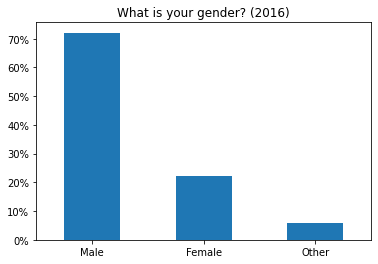

In [ ]:
question_bar_plot(df_2016, 2, 2016);

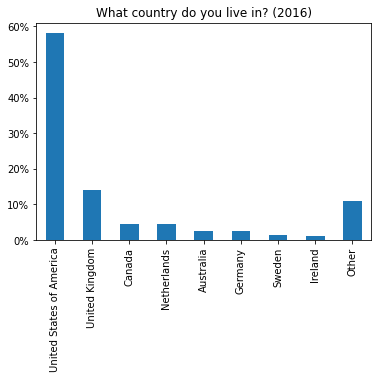

In [ ]:
question_bar_plot(df_2016, 3, 2016, True);

In [ ]:
bar_plot_interactive(df_2016, 3, 2016)

## II. Gender and Mental Disorders in Tech

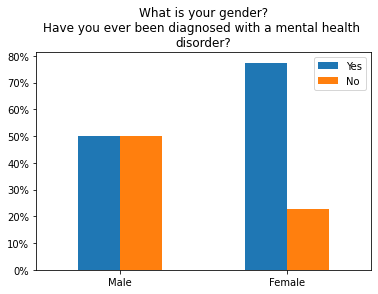

In [ ]:
question_bar_plot_grouped(df_2016, 2, 34, 2016, False);

We see that half of men are diagnosed with a mental disorder while a majority of women are.
<br>
However, this could be explained by sample bias. While our target population is people working in tech, this survey was done using voluntary participation, so it makes sense that people with mental disorders are going to be more interested in this survey.
<br>
On top of this, if we think that men are more likely to answer this survey, we can be in a situation akin to
<a href =https://en.wikipedia.org/wiki/Berkson%27s_paradox>The Berkson's Paradox</a>,
where there is an illusory anti-correlation between variables which are selected for.

As a way to validate this discrepancy, I will look at the family histories of men and women.

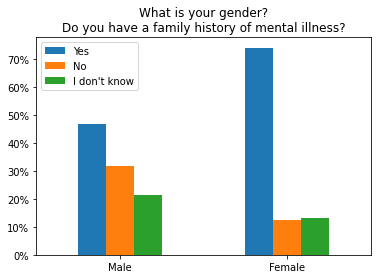

In [ ]:
question_bar_plot_grouped(df_2016, 2, 6, 2016, False);

We also see a big difference in their family history. This makes sense, as mental disorders can be transmited both through genes and through environment.
<br>
In the general population, those distributions would be the same, so it must be that this sample is an atypical one or that men or women give biased answers or a little of both.

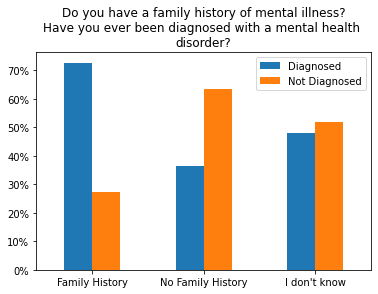

In [ ]:
question_bar_plot_grouped(df_2016, 6, 34, 2016, False,
                          below=["Family History", "No Family History", "I don't know"],
                          legend=["Diagnosed", "Not Diagnosed"]
                          );

As expected, we see a correlation between being diagnosed with a mental disorder and having a family history of mental illness.

### Hypothetical model

Since ancient times, madness, creativity and unconventionality were seen as related. To qoute Plato: "Madness can be a divine release of the soul from the yoke of custom and convention".
<br>
Modern research also suggests there is a link between mental disorders and creativity.
<br>
Also, within our societies, people who act contrary to stereotypes experience negative social consequences.[[1]](#1) I find it intuitive, then, to speculate that creative people will act and think less in line with those stereotypes, as it is generally harder for them to fit into societal expectations.
<br>
Specifically, in our case, gender stereotypes could affect the decision to enter and prepare for a tech job. This should be moderated by creativity, which, through it's association with mental disorders, could explain the discrepancy in mental health between males and females in tech.

* <font color='E66478'> Observed </font>
* <font color='6CA6C1'> Unobserved </font>

![picture](https://drive.google.com/uc?id=1HVSDwxa7VHuWhbJoyi9j5iIGR_TSZ2Mk)


\* Within Shared Vulnerability Model, genes that cause greater creativity also cause greater risk of mental illness. It is only the variation in this cluster of genes which is captured by the "Genes" variable. Only the genes that are not within sex chromosomes are taken into account.

\**
<br>
* Internalized male stereotypes = -1
* Internalized female stereotypes = +1
* No internalization = 0
* Weaker internalization is closer to zero
* Higher creativity leads to weaker internalization




![picture](https://drive.google.com/uc?id=1mMpgnv4a-Qa93TNTfpJ6n9aFkuYgSwlQ)

#### Sources:

<a name="1"></a>
[1] 
<a href=https://www.researchgate.net/publication/8408812_Reactions_to_Counterstereotypic_Behavior_The_Role_of_Backlash_in_Cultural_Stereotype_Maintenance>
Reactions to Counterstereotypic Behavior: The Role of Backlash in Cultural Stereotype Maintenance
</a>

Genes -> Creativity, Genes -> Mental Disorders:
<br>
<a name="2"></a>
[2]
<a href=https://scottbarrykaufman.com/wp-content/uploads/2013/10/Carson-IR.pdf> Creativity and Psychopathology: A Shared Vulnerability Model </a>

Creativity -> Internalized Gender Stereotypes (moderation):
<br>
<a name="3"></a>
[3]
<a href=https://www.ingentaconnect.com/content/sbp/sbp/2000/00000028/00000005/art00002> Psychological Androginy and Creativity </a>
<br>
Study determined correlation, but not causation

Internalized Gender Stereotypes -> Carrer Choice:
<br>
<a name="4"></a>
[4]
<a href=https://link.springer.com/article/10.1007/BF01551499>
Influence of maternal gender-role beliefs and role satisfaction on daughters' vocational interests

#### Controlling for mental disorders (FH -> MD -> FinT)

I will investigate the relationship between family history and gender by controlling for mental disorders. I will group the results into people with and without mental disorder. I expect, according to my model, that there will still be an unexplained relationship.

In [ ]:
df_mi_2016 = df_2016[df_2016["Answer34"] == "Yes"]
df_no_mi_2016 = df_2016[df_2016["Answer34"] == "No"]

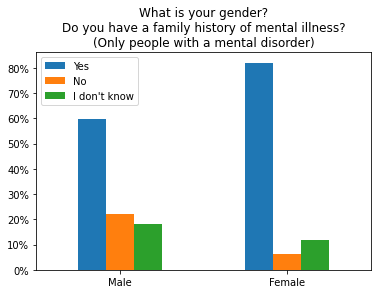

In [ ]:
question_bar_plot_grouped(df_mi_2016, 2, 6, 2016, False, 
                          additional_info="(Only people with a mental disorder)");

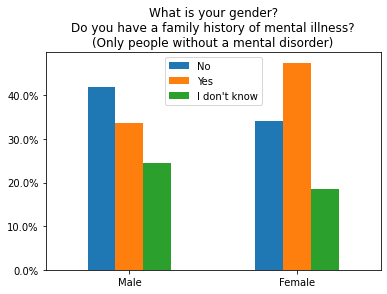

In [ ]:
question_bar_plot_grouped(df_no_mi_2016, 2, 6, 2016, False,
                          additional_info="(Only people without a mental disorder)");

We see that the difference between men and women in family history persists. So it still needs an explanation. This is evidence that The Berkson's Paradox doesn't fully explain the discrepancy in mental disorders between men and women.

#### Heritability as an indication of causation

We can study the relation between overrepresentation and heritability of a disorder in order to get a sense of the causal relationship between mental disorders and women in tech.
<br>
We have three posibilities:
<br>
1. Working in tech increases the risk for mental disorders in womem (FinT -> MD)
<br>
We expect negative correlation
2. Mental disorders increase the likelihood for women to go into tech (MD -> FinT)
<br>
We expect no correlation
3. Common factor - endorsed by my model (MD <- Genes -> FinT)
<br>
We expect positive correlation

I find 1. and 2. to be unlikely and 3. to be most likely. 
<br>
However,
<a href=https://www.thetechedvocate.org/what-fewer-women-in-stem-means-for-their-mental-health/>this</a> persuasive article presents a way in which underrepresantation of women in tech leads to mental health problems, so a type 1 scenario.
<br>
Let's see what the data says!

In [ ]:
#@title

names = ["anxiety", "adhd" , "ocd", "mood" ,"ptsd" ,"personality"]
over = np.array([0.44, 2.05, 0.48, 0.61, 0.18, 1.11])
her = np.array([35, 70, 47, 41.1, 20, 29.6])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


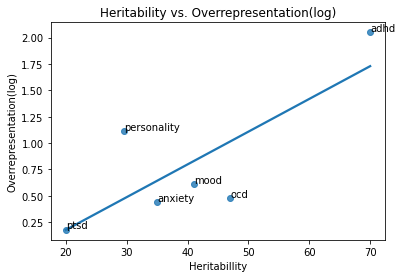

In [ ]:
#@title

ax = sns.regplot(her, over, ci=None)

plt.title('Heritability vs. Overrepresentation(log)')
# Set x-axis label
plt.xlabel('Heritabillity')
# Set y-axis label
plt.ylabel('Overrepresentation(log)')


def label_point(x, y, val, ax):
    for i in range(len(val)):
        ax.text(x[i]+.04, y[i]+.01, str(val[i]))

label_point(her, over, names, plt.gca()) 

Heritability and overrepresentation of women seem correlated. I will further study the statistical significance of this apparent relation.

In [ ]:
#@title
result = pearsonr(her, over)
print('Pearson Test:')
print(f'r: {result[0]:.3f}')
print(f'one-tailed p value: {result[1]/2*100:.2f}%')

Pearson Test:
r: 0.786
one-tailed p value: 3.19%


An assumption of Pearson Test is that variables are normally distributed. In our case the x variable (Heritability) can only take values between 0 and 100. Also, the y variable has unequal errors, as there is a different number of persons which have each mental disorder. This suggests that a weighted correlation test is necessary.
<br>
I conclude that it's likely that the normality assumption is not satisfied.

The Spearman Test has more minimal assumptions. However, the fact that only takes into consideration the ordering of the data points, it's vulnerable to false negatives.

In [ ]:
#@title

result = spearmanr(her, over)

print('Spearman Test:')
print(f'r: {result[0]:.3f}')
print(f'one-tailed p value: {result[1]/2*100:.2f}%')

Spearman Test:
r: 0.600
one-tailed p value: 10.40%


##### Code for 3rd validation

In [ ]:
n_females = df_2016[df_2016["Answer2"] == "Female"].shape[0]
n_males = df_2016[df_2016["Answer2"] == "Male"].shape[0]

In [ ]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    divided = cov(x, y, w)
    divisor = np.sqrt(cov(x, x, w) * cov(y, y, w))
    if divisor == 0:
      if divided >= 0:
        return 1
      else:
        return -1
    return divided / divisor

In [ ]:
def weighted_variance(values, weights):
  average = np.average(values, weights=weights)
  return np.average((values-average)**2, weights=weights)

In [ ]:
def variance_likelyhood(x, n):
  weights = []

  l_space = np.linspace(0, 1, 99999, endpoint=False)[1:]
  log_space = np.log(l_space)

  for p in l_space:
    lk = np.longdouble(p)**x * np.longdouble(1-p)**(n-x)
    weights.append(lk)
  
  return weighted_variance(log_space, np.array(weights))

In [ ]:
def weight(p1, p2):
  x = p1 * n_females
  y = p2 * n_males

  var1 = variance_likelyhood(x, n_females)
  var2 = variance_likelyhood(y, n_males)

  return 1 / (var1 + var2)

In [ ]:
p_females = [0.1933, 0.0739, 0.0123, 0.2407, 0.0417, 0.0265]
p_males = [0.1311, 0.1148, 0.0125, 0.1311, 0.0212, 0.0180]

weights = np.array([weight(p_females[i], p_males[i]) for i in range(6)])

In [ ]:
c_real = corr(over, her, weights)

In [ ]:
more_c = 0
n = 10000
for i in range(n):
  her_rs = random.choice(her, 6, replace=False)
  co = corr(over, her_rs, weights)
  if co >= c_real:
    more_c += 1

##### Validation through resampling (weighted)

Now I will conduct a more complex test, but which I think is the most rigorous. The method is as follows:
1. Establish weights for the different variables based on the expected variance of the error for the OR(log) variable (I will use the inverse of variance)
2. Compute the weighted correlation coefficient (Pearson)
3. Resample the H variable 10.000 times and compute the weighted corrrelation coeficient
4. See how likely it is that the simulated correlation coefficient exceeds the true one and use this result as a p-value

More on step 1:
<br>
The variance of errors will be equal to the variance of the likelyhood function given the observation x.
<br>
$Var(\epsilon)=Var(L(p|x)-Avg(L(p|x)))=Var(L(p|x))$


In [ ]:
#@title

print("Resampling test")
print(f'r: {c_real:.3f}')
print(f'one-tailed p value: {more_c/n*100:.2f}%')

Resampling test
r: 0.917
one-tailed p value: 2.55%


#### A fact that might contradict my theory:

When I analyzed the relationship between self-employement and mental disorders I found no correlation. I didn't expect this to be the case, as I thought self-employed people would be more creative. 
<br>
However, self-employment didn't seem to be correlated with anything else.

## III. Acceptance of mental disorders and gender

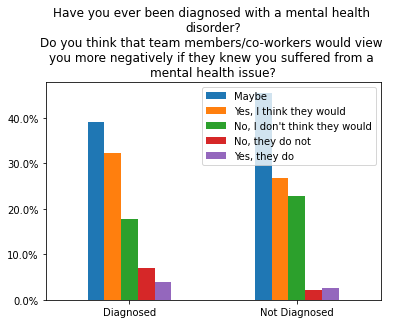

In [ ]:
question_bar_plot_grouped(df_2016, 34, 114, 2016, rot=False, 
                          sensitivity0=0.0, sensitivity1=0.0,
                          below=["Diagnosed", "Not Diagnosed"]
                          );

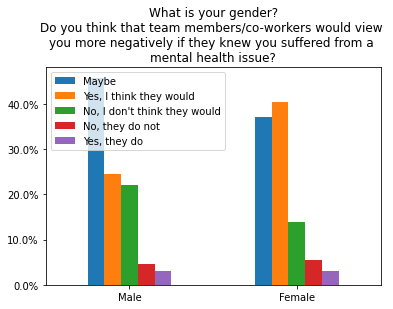

In [ ]:
question_bar_plot_grouped(df_2016, 2, 114, 2016, rot=False, 
                          sensitivity0=1.0, sensitivity1=0.0,
                          );

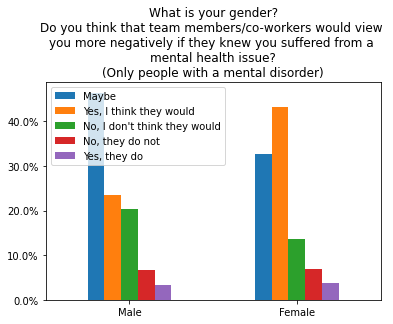

In [ ]:
question_bar_plot_grouped(df_mi_2016, 2, 114, 2016, False,
                          sensitivity0=2.0, sensitivity1=0.0,
                          additional_info="(Only people with a mental disorder)");

We see that diagnosed people are more likely to believe that their colleagues would view them negatively.
<br>
However, there is also a discrepancy between men and women, with women more likely to think their colleagues would view them negatively.
<br>
My interpretation is that this is not due to bias. As we see in the third graph, there is a slightly higher proportion of women answering "Yes they do". I believe women with mental disorders truly have a harder time being accepted than men, in the same situation.

# Cunclusion

In light of this investigation, I believe that mental disorders and gender interact in ways which are relevant both for gender inclusivity and for neuro-inclusivity. I believe that those two kinds of inclusivity mutualy reinforce each other. Therefore, I think that a more holistic approach to inclusivity is a promising strategy.